# Workout data exploration

Kyle Ziegler 11/2021

***

## Project goals and process

- With professor Brooks as our client, it's crucial that he is able to get insight into the data, and learn about trends, optimizations, and workout metrics specific to his workout techniques that could help him improve in the future, or track how far he has come.
- I notice that the strava dataset has multiple areas with missing values, outliers, and columns that I wish were supplied to us - such as sport, the device type used, etc. With the data given, there were some assumptions that I needed to make, and I'll outline them as I make them either inline, or in my summary of the plot.


## Rules for writing and sharing computational analyses

1. Tell a story for an audience: I hope that you enjoy the insight into this dataset, and that my comments add value to the narrative. It is my goal for you to walk away with something new and insightful from the athletic metrics provided. In order to make the story more compelling, I use the latter two pieces in my analysis to build on top of each other. In part 2 you will get more familiar with a single workout, and in part 3 I'll use an advanced graph to demonstrate some datapoints discussed in part 2.
2. Document the process, not just the results: See my inline comments and notes before and after a plot/piece of code. I assume that the audience has some experience with data science and statistics so I do not explain every small detail, but I hope that there are enough commments and explanations for the reader to understand my thought process. It is my goal for the reader to fully understand what the data source is, what manipulations took place, and how I created the visual artifacts.
3. Use cell divisions to make steps clear: I have grouped cells into a logical division that dvides different topics. What I mean by this is some cells will just be importing libraries, others for preprocessing, and some for displaying the visual artifacts.
4. Modularize code: I did not build an extensive enough of a platform to warrent turning the code into a library, but with the objective of building out tooling for people to leverage or a more complex analysis it could be worth turning some components into a library to make your primary analysis easier to interpret and more legible.
5. Record dependencies: Note the packages that I am importing, and go through the dependencies section.
6. Use version control: I used git to version my notebooks and datasets.
7. Build a pipeline: I did not build a pipeline for this notebook. Options here include using kubeflow or Tensorflow Extended.
8. Share and explain your data: The code and data is all outlined here, either in this python notebook or in the zip. If there are areas in the code I felt needed further explanation, I have added my comments there. I made it a point to track data manipulation steps that I was taking so that the reader feels there is little ambiguity in the analysis.
9. Design your notebooks to be read, run, and explored: I have included everything in this directory that is needed to run and reproduce the results that I have shown here.
10. Advoc`ate for open research: I may post this analysis with a different dataset on the backend - finding another open healthcare dataset from Kaggle.


## Code and Visualizations

### Dependancies

- Throughout this analyis, I'll leverage Seaborn, Folium, and a few basic python packages such as numpy for vector computations, and pandas for dataframes. I'll also use some standard features from python for datetime computations.

In [24]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from datetime import datetime

### Part 1: Workout trends over time
- In this first example, we'll get an overview over all the workouts that are located in the dataset given, and plot those against distance on the Y axis.
- Assumptions: Each datafile is a different workout, and that the workout type can be determined through ground time.
- Process: I have converted distance into miles, and performed a groupby on workouts summing them together.
- Analysis: We notice that workouts are concentrated in July and August, until the start of September where it appears that there is a few weeks of break, before going into longer distance workouts. This visual gives us a great overview of the workouts that took place - when, how long, what type, and how frequent. This allows us to dive into further analysis based off of the findings here, or identify where the gaps are in the dataset. There are many unknowns, and the better we can visualize the dataset, the easier it is to identify what manipulation or data engineering needs to take place.

Cycling    41
Running     8
Name: sport, dtype: int64


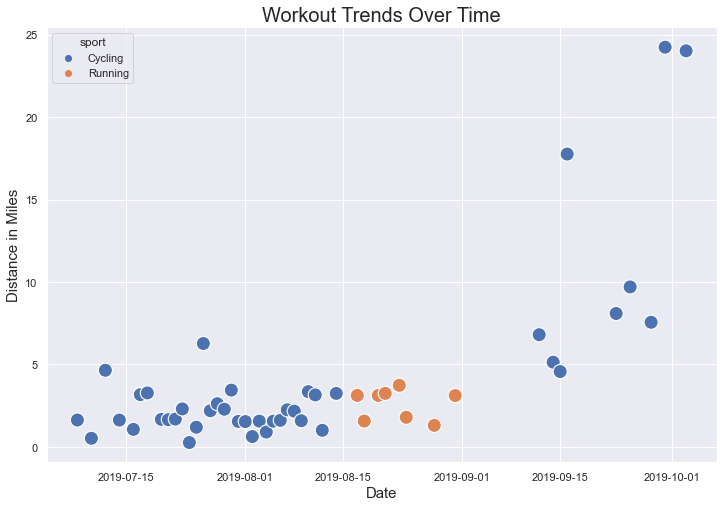

In [111]:
# %%timeit
df = pd.read_csv("./strava.csv")
sns.set_theme(style="darkgrid")

df.groupby("datafile")
df.sort_values("timestamp", ascending=True)
df.dropna(subset=["timestamp", "distance"])
df["dates"] = pd.to_datetime(df['timestamp'])

df["dates"] = df["dates"].dt.normalize()

# Attempted to analyze speed, will take too much time and presents challenges such as how do I classify the entire
# workout? even with cycling the rider will be slowing down and speeding up, I'd have to create an additional 
# assumption where if 90+% of datapoints are above X speed it's cycling, else it's running. Or I would have to sort 
# and figure what the maximum speed was during the duration of the workout and use that as the determining factor.

# speed_analysis = df.copy()
# speed_analysis["speed"] = speed_analysis["speed"].apply(lambda x: x*0.000000001)
# speed_analysis.sort_values("speed", ascending=False)
# print(speed_analysis.head())

# df.to_csv("raw.csv")

# Check of ground time is not NaN, if it is NaN I make an assumpetion here that
# the sport is cycling, since you can not have the ground time metric for that
# sport.
def getSport(x):
    if np.isnan(x["Ground Time"]):
        return "Cycling"
    else:
        return "Running"
dfg = df.groupby("dates").last()

# Convert to miles
dfg["distance"] = dfg["distance"].apply(lambda x: x/1609)

dfg["sport"] = dfg.apply(lambda x: getSport(x), axis=1)

print(dfg.sport.value_counts())
# print(dfg.head())
dfg.to_csv("output.csv")

# Multi workout analysis
plt.subplots(figsize=(12, 8))
ax = sns.scatterplot(data=dfg, x="dates", y="distance", hue="sport", s=200)
# ax.set(ylabel="Distance in miles", xlabel="Date")
plt.title("Workout Trends Over Time", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Distance in Miles", fontsize=15)
plt.show()

# plt.subplots(figsize=(8, 8))
# heart_rate_time = sns.lineplot(y=df['heart_rate'], data=df, hue="datafile")



### Part 2: Insight into a single workout
- In this section of the anlysis, I have decided to look at a single workout and dive into what could be going on at various points. I have done a rolling average with a hann window size of 5.
- In order to create this chart, I filter by a single workout that I have chosen, and I have droped rows that contain NA values in all the charts I will be plotting here.
- In the first histogram, I plot the heard rate and count in order to get an idea of where the athletes heart rate was for the duration of the workout.
- For the second example, I demonstrate a line chart. I plot the heart rate over the course of the workout. In this example it is evident that there is a short "warmup" period before the atheletes heart rate starts steadying at 160, and slowly climbs to 180. I also notice that there is not a cooldown period. Since we are only given the dataset, it could be that the athlete turned off monitoring before the cooldown period and that is why we do not have the data.
- In the third example, I show a distribution KDE plot with 20 bins, and this does a good job at showing us density of points with respect to power and speed. I noteice that most of the power is generated around 2.8 meters per second. The athlete can use this information to better understand power trends, when taking into account more data such as weather, or time of day, this can provide more insight into how they are performing and what adjustments they can make. Ie for the same speed we may notice that the athlete is making different power depending on what shows they are wearing, etc.
- I have adjusted the axis titles, font sizes and seaborn theme for readability and presentation aesthetics.

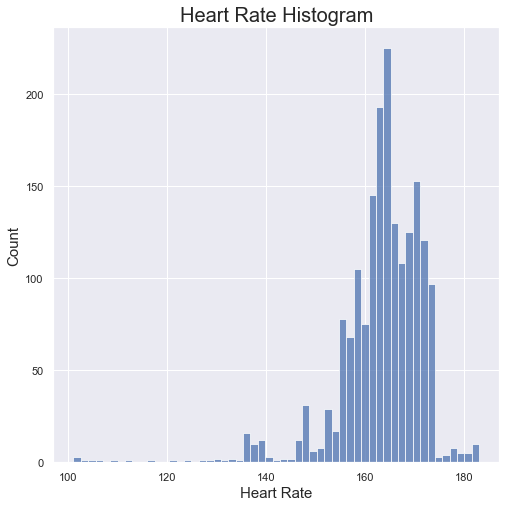

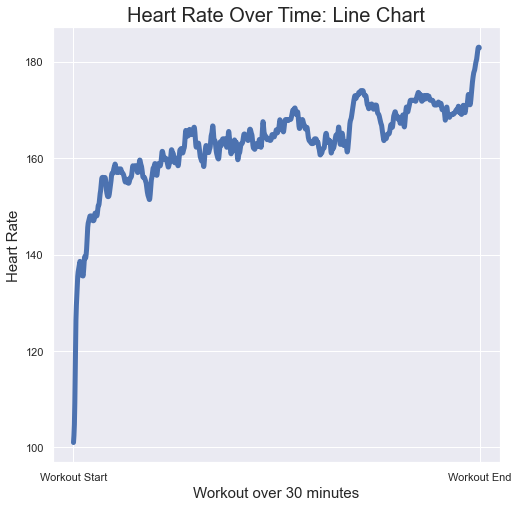

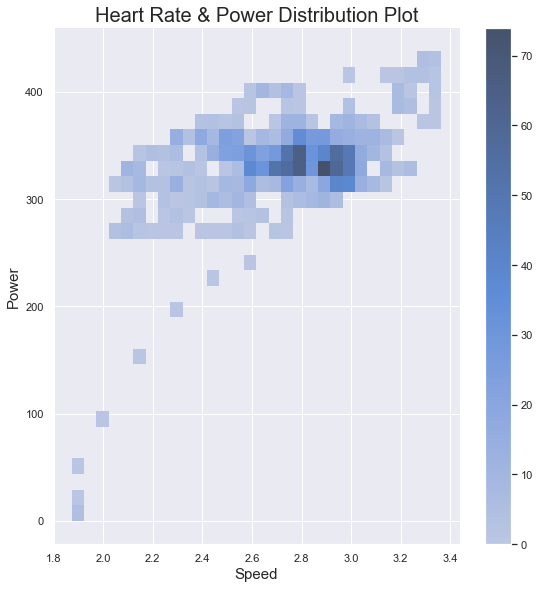

In [96]:
df2 = df[df["Power"].notnull() & (df["datafile"] == "activities/2786247269.fit.gz")]

# Romming mean to fill missing values
h_mean = df2.rolling(window=10, win_type="hann", min_periods=1, on="timestamp").mean()
# print(h_mean.heart_rate.value_counts)

plt.subplots(figsize=(8, 8))
sns.histplot(x=h_mean['heart_rate'], data=h_mean)
plt.title("Heart Rate Histogram", fontsize=20)
plt.xlabel("Heart Rate", fontsize=15)
plt.ylabel("Count", fontsize=15)

plt.show()


plt.subplots(figsize=(8, 8))
heart_rate_time = sns.lineplot(x=h_mean["timestamp"], 
                                y=h_mean['heart_rate'], 
                                linewidth = 5,
                                data=h_mean)

# Note tick values are done off of the number of datapoints for time. There are 1827 in this set, so that is 
# the right most data point, or the end of the arrary.
plt.xticks([1,1827],['Workout Start','Workout End'])
plt.title("Heart Rate Over Time: Line Chart", fontsize=20)
plt.xlabel("Workout over 30 minutes", fontsize=15)
plt.ylabel("Heart Rate", fontsize=15)
plt.show()

# plt.subplots(figsize=(8, 8))          
sns.displot(x="enhanced_speed", y="Power",
            bins=30,
            height=8,
            cbar=True,
            data=h_mean)
plt.title("Heart Rate & Power Distribution Plot", fontsize=20)
plt.xlabel("Speed", fontsize=15)
plt.ylabel("Power", fontsize=15)
plt.show()


### Part 3: Advanced plot - Folium map with power visualization
- In this final visual artifact, I create a map using the Folium library to show the running route that was taken, and the power generated at each stage of the journey. Building on top of the graphs that were created before this with respect to heart rate and speed versus power, this chart gives us another viual into different parts of the atheletes workout.
- In order to create this chart, I create a new dataframe called mdf, where I filter by the workout we have been working on, and drop na values that are located in the Power and lat/long coordinates. I also use the degree conversion shown in lecture. In order to plot the line showing the running route, I use the ColorLine function in the Folium library which takes 2 essential arguments including the lat/long points and a datapoint for the color. I have chosen to reduce the number of colors in our pallet, to get a better idea what was happening over this shorter run. Tooltips have been added marking the start and the end of the run.
- Interpretation: Building on top of what we learned before on the athletes hear rate over the course of the workout, we can see that less power was generated towards the end of the workout. Notice how the line changes from a darker read to yellow, and then eventually to green. What this tells me is that even though the athelete was generating less power towards the end of their run, it may take more time for that to reflect in the heart rate sensor. For example, it may take 5+ min of rest for it to come down to less than 120bpm. Throughout the course of the run, the athelete oscillates between what it seems to be walking and running, comparing that with our heart rate over time above, we can see those slight dips throughout the run.
- Feel free to scroll around the course of the run and gather your own thoughts as well.

In [125]:
# Used to hide some warnings generated by the library.
import warnings
warnings.filterwarnings('ignore')

mdf = df[df["datafile"] == "activities/2786247269.fit.gz"]
mdf.dropna(inplace=True, subset=["position_lat", "position_long", "Power"])

mdf["position_lat_degrees"] = mdf["position_lat"] * ( 180 / 2**31 )
mdf["position_long_degrees"] = mdf["position_long"] * ( 180 / 2**31 )

import math
def lat2y(a):
  return 180.0/math.pi*math.log(math.tan(math.pi/4.0+a*(math.pi/180.0)/2.0))
mdf["position_lat_degrees_mercantor"]=mdf["position_lat_degrees"].apply(lat2y)



# print(mdf.head())

# Start and end markers
m=folium.Map(location=[mdf["position_lat_degrees"].iloc[0], mdf["position_long_degrees"].iloc[-1]], zoom_start=15)
folium.Marker([mdf["position_lat_degrees"].iloc[0],mdf["position_long_degrees"].iloc[0]], 
              popup="Workout Start").add_to(m)
folium.Marker([mdf["position_lat_degrees"].iloc[-1],mdf["position_long_degrees"].iloc[-1]], 
              popup="Workout End").add_to(m)


route=folium.ColorLine(positions=zip(mdf["position_lat_degrees"],mdf["position_long_degrees"]),
                      nb_steps=4,
                    weight=5,
                    smooth_factor = 20,
                    colors=mdf.Power).add_to(m)

display(m)